In [1]:
import jijmodeling as jm
import ommx.v1
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple

import networkx as nx
import matplotlib.pyplot as plt

if not hasattr(np, "alltrue"):
    np.alltrue = np.all

In [2]:
G = nx.Graph()
num_nodes = 5
edges = [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}

cut_solution = {(1,): 1.0, (2,): 1.0, (4,): 1.0}
edge_colors = []

In [3]:
def get_edge_colors(
    graph, cut_solution, in_cut_color="r", not_in_cut_color="b"
) -> Tuple[List[str], List[str]]:
    cut_set_1 = [node[0] for node, value in cut_solution.items() if value == 1.0]
    cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]

    edge_colors = []
    for u, v, _ in graph.edges(data=True):
        if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
            edge_colors.append(in_cut_color)
        else:
            edge_colors.append(not_in_cut_color)
    node_colors = ["#2696EB" if node in cut_set_1 else "#EA9b26" for node in G.nodes()]
    return edge_colors, node_colors

edge_colors, node_colors = get_edge_colors(G, cut_solution)

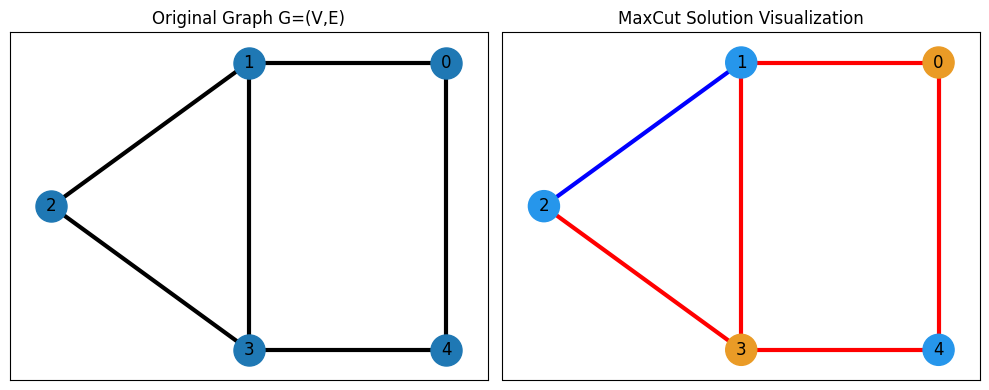

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title("Original Graph G=(V,E)")
nx.draw_networkx(G, pos, ax=axes[0], node_size=500, width=3, with_labels=True)
axes[1].set_title("MaxCut Solution Visualization")
nx.draw_networkx(
    G,
    pos,
    ax=axes[1],
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)

plt.tight_layout()
plt.show()

In [5]:
def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem


problem = Maxcut_problem()
problem

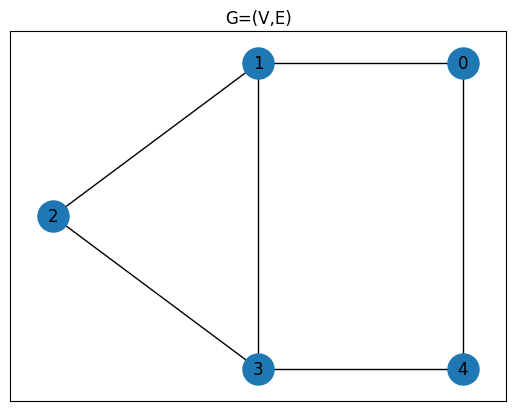

In [6]:
import networkx as nx
import numpy as np
from IPython.display import display, Latex

G = nx.Graph()
num_nodes = 5
edges = [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)

weight_matrix = nx.to_numpy_array(G, nodelist=list(range(num_nodes)))

plt.title("G=(V,E)")
plt.plot(figsize=(5, 4))

nx.draw_networkx(G, pos, node_size=500)

In [7]:
V = num_nodes
E = edges

data = {"V": V, "E": E}

data

{'V': 5, 'E': [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]}

In [8]:
interpreter = jm.Interpreter(data)
compiled_model = interpreter.eval_problem(problem)

In [9]:
import qamomile.core as qm

qaoa_converter = qm.qaoa.QAOAConverter(compiled_model)

qaoa_converter.ising_encode()

qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

p = 5

qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

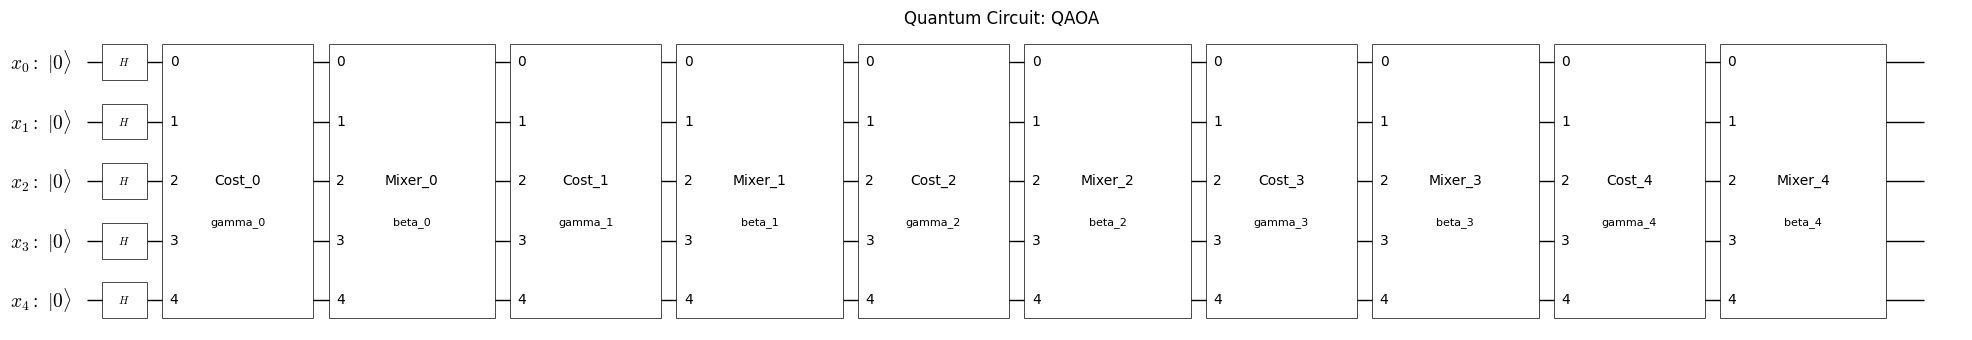

In [10]:
from qamomile.core.circuit.drawer import plot_quantum_circuit

plot_quantum_circuit(qaoa_circuit)

In [11]:
import qamomile.qiskit as qm_qk

qk_transpiler = qm_qk.QiskitTranspiler()

# Transpile the QAOA circuit to Qiskit
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)

# Transpile the QAOA Hamitltonian to Qiskit
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
hamiltonian = qk_hamiltonian.to_list()
hamiltonian

[('IIIZZ', (0.5+0j)),
 ('ZIIIZ', (0.5+0j)),
 ('IIZZI', (0.5+0j)),
 ('IZIZI', (0.5+0j)),
 ('IZZII', (0.5+0j)),
 ('ZZIII', (0.5+0j)),
 ('IIIII', (-3+0j))]

In [12]:
import fireopal as fo
from qiskit import QuantumCircuit
from qiskit import qasm3
import numpy as np
from scipy.optimize import minimize
from fireopal.types import PauliOperator

In [ ]:
api_key = ""
fo.authenticate_qctrl_account(api_key=api_key)

token = ""
instance = ""
credentials = fo.credentials.make_credentials_for_ibm_cloud(
    token=token, instance=instance
)

Q-CTRL authentication successful!


In [14]:
# Convert to OpenQASM3
qk_circuit.measure_all()
qasm_circ = qasm3.dumps(qk_circuit.decompose())

In [15]:
init_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)

In [16]:
from qiskit_ibm_runtime.fake_provider import FakeMumbaiV2
backend = FakeMumbaiV2()

In [17]:
shot_count = 2048
backend_name = backend.name

In [18]:
# Store the history of calculated expectation values
expectation_value_history = []
trab = []

def objective_function(parameters):
    """
    Calculates the cost based on the quantum circuit's outcome.
    Maps numerical parameters to the circuit parameters, runs the circuit, and computes the expectation value.
    """
    # Map the parameters to the circuit parameters
    parameters_dict = {param.name: val for param, val in zip(qk_circuit.parameters, parameters)}
    observables = PauliOperator.from_list(hamiltonian)
    job = fo.estimate_expectation(
        circuits=[qasm_circ],
        shot_count=shot_count,
        credentials=credentials,
        backend_name=backend_name,
        parameters=[parameters_dict],
        observables=observables,
    )
    expectation_value = job.result()["expectation_values"][0]

    # Save the intermediate cost values without additional calls to this objective function
    global expectation_value_history
    expectation_value_history.append(expectation_value)

    return expectation_value

In [19]:
circuit_errors = fo.validate(
    circuits=[qasm_circ],  # Your OpenQASM circuit(s) as a list
    credentials=credentials,        # Credentials for your quantum hardware provider
    backend_name=backend_name       # Name of the backend device
)

print(f"Number of circuit errors found: {len(circuit_errors['results'])}")

Number of circuit errors found: 0


In [20]:
# Set options to limit max iterations
options = {"maxiter": 1000, "disp": True}

# Minimize the objective function using COBYLA method
result = minimize(
    objective_function, init_params, method="COBYLA", tol=0.01, options=options
)

/home/nemo/anaconda3/envs/qiskit/lib/python3.12/site-packages/qctrlworkflowclient/functions.py:191: RuntimeWarning: Using a simulator for executing the circuit(s). Q-CTRL will not show significant improvement on simulators because they lack realistic noise sources for Q-CTRL to suppress.
  warn(warning, RuntimeWarning)



   Normal return from subroutine COBYLA

   NFVALS =   74   F =-4.768555E+00    MAXCV = 0.000000E+00
   X = 1.988279E-01   9.275956E-01  -5.451408E-01   1.676009E+00   1.482689E-01
      -4.411650E-01  -3.150794E-01   2.364789E-01  -1.135830E+00  -2.652950E-01


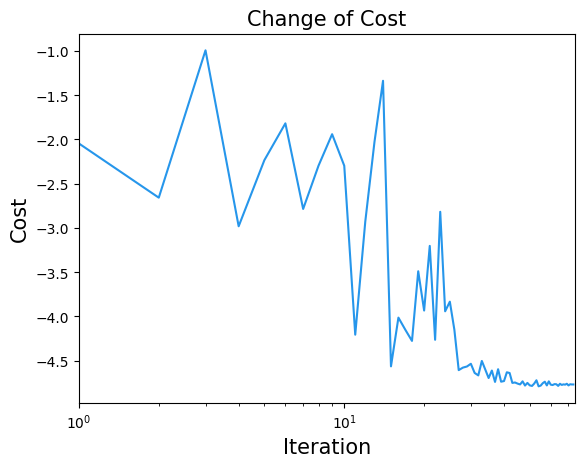

In [21]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(expectation_value_history, label="Cost", color="#2696EB")
plt.show()

In [22]:
import qiskit.primitives as qk_pr
# Run Optimized QAOA circuit
sampler = qk_pr.StatevectorSampler()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

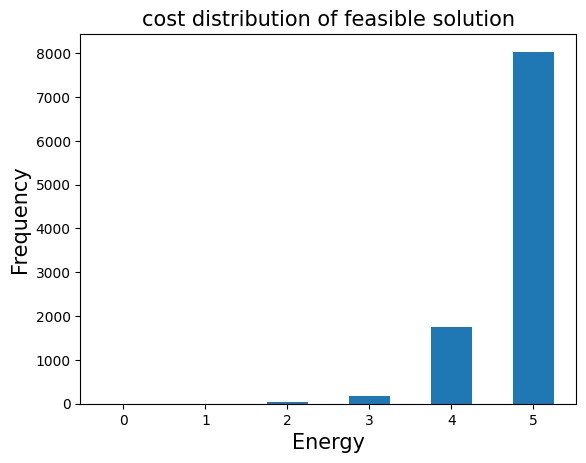

In [23]:
import matplotlib.pyplot as plt

sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])
plot_data = {}
energies = []
frequencies = []

# Create a dictionary to group energies and count their frequencies
from collections import defaultdict
energy_freq = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy_freq[sample.objective] += 1

energies = list(energy_freq.keys())
frequencies = list(energy_freq.values())

plt.bar(energies, frequencies, width=0.5)
plt.title("cost distribution of feasible solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()

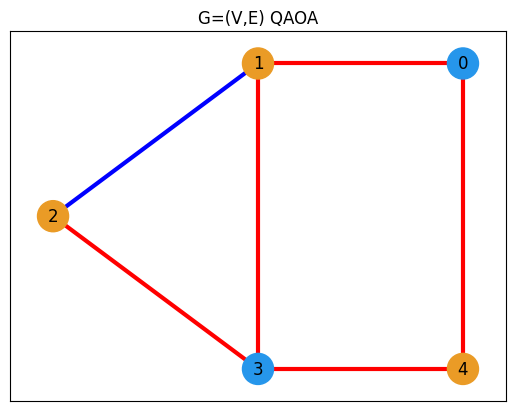

In [24]:
best_values = sampleset.best_feasible_unrelaxed.extract_decision_variables("x")
edge_colors, node_colors = get_edge_colors(G, best_values)

plt.title("G=(V,E) QAOA")
plt.plot(figsize=(5, 4))
nx.draw_networkx(
    G,
    pos,
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)